In [1]:
import numpy as np
import pandas as pd
import pysam
from pysam import AlignmentFile
import hashlib

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

In [2]:
mem_path = "../../tmp/mem/merged_sorted.bam" # bwa mem aligned
bwasw_path = "../../tmp/bwasw/merged_sorted.bam" # bwasw aligned
mm2_path = "../../tmp/mm2/merged_sorted.bam" # mm2 aligned

def get_scores(bam_file):
    af = AlignmentFile(bam_file)
    scores = []

    for idx, align in enumerate(af):
        if not align.is_unmapped:
            align_score = align.get_tag("AS")
        else:
            align_score = 0

        row = {
            'name': align.to_dict()['name'],
            'score': align_score
        }
        scores.append(row)

    df = pd.DataFrame(scores)
    return df

mem = get_scores(mem_path)
bwasw = get_scores(bwasw_path)
mm2 = get_scores(mm2_path)

print("bwa mem")
print(mem.shape)
print(mem['score'].describe())

print()
print("bwa bwasw")
print(bwasw.shape)
print(bwasw['score'].describe())

print()
print("mm2")
print(mm2.shape)
print(mm2['score'].describe())

bwa mem
(472137, 2)
count    472137.000000
mean        194.754421
std         170.865906
min           0.000000
25%          79.000000
50%         137.000000
75%         249.000000
max        2429.000000
Name: score, dtype: float64

bwa bwasw
(459023, 2)
count    459023.000000
mean        241.689118
std         198.865262
min           0.000000
25%         105.000000
50%         179.000000
75%         311.000000
max        2739.000000
Name: score, dtype: float64

mm2
(413120, 2)
count    413120.000000
mean        591.408738
std         460.333117
min        -437.000000
25%         268.000000
50%         454.000000
75%         768.250000
max        5676.000000
Name: score, dtype: float64


Text(0.5, 0, 'Alignment Score (log)')

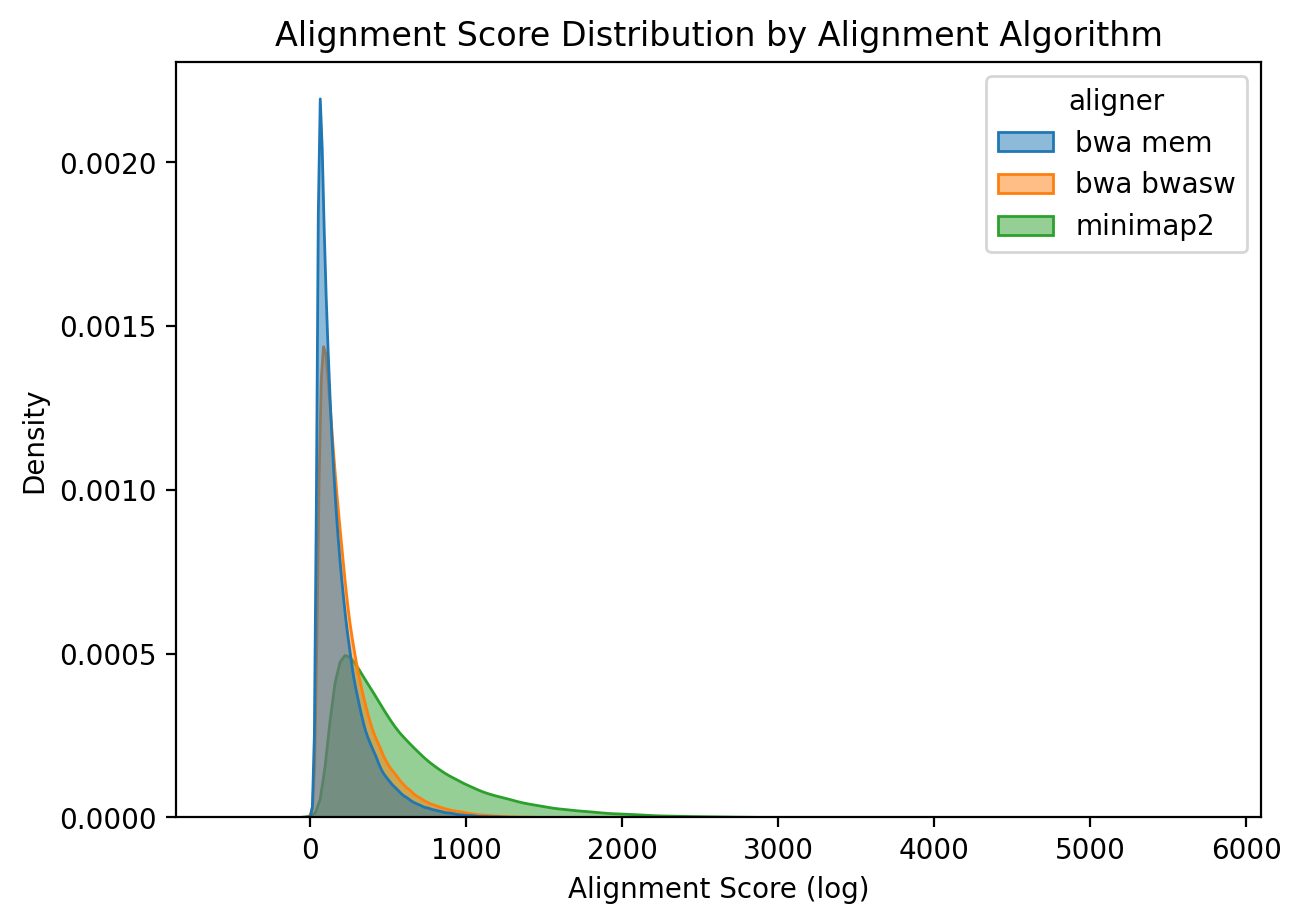

In [3]:
mem['aligner'] = 'bwa mem'
bwasw['aligner'] = 'bwa bwasw'
mm2['aligner'] = 'minimap2'


df = pd.concat([mem, bwasw, mm2], ignore_index=True)

# min_val = 30
# df['log_score'] = np.where(df['score'] <= min_val, min_val, df['score'])
# df['log_score'] = np.log(df['log_score'])

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (7, 5)

sns.kdeplot(data=df,
             x='score',
             hue='aligner',
             fill=True,
             alpha=0.5)

plt.title("Alignment Score Distribution by Alignment Algorithm")
plt.ylabel("Density")
plt.xlabel("Alignment Score (log)")

In [4]:
"""look at coverage"""

mem_path = "../../tmp/mem/custom_coverage_table.csv"
bwasw_path = "../../tmp/bwasw/custom_coverage_table.csv"
mm2_path = "../../tmp/mm2/custom_coverage_table.csv"

mem = pd.read_csv(mem_path)
bwasw = pd.read_csv(bwasw_path)
mm2 = pd.read_csv(mm2_path)

mem['aligner'] = 'bwa mem'
bwasw['aligner'] = 'bwa bwasw'
mm2['aligner'] = 'minimap2'

df = pd.concat([mem, bwasw, mm2], ignore_index=True)
df = df.sort_values(by='rname')
df.head()

,rname,total_length,n_bps_no_coverage,perc_coverage,mean_depth_bp,mean_depth_fragment,max_depth,min_depth,aligner
0,NC_000067.7,195154279,192225173,0.015009,0.045680,29.062464,5033,0,bwa mem
122,NC_000067.7,195154279,191772917,0.017327,0.053240,24.442401,4871,0,minimap2
61,NC_000067.7,195154279,192149231,0.015398,0.060029,25.709512,6605,0,bwa bwasw
128,NC_000068.8,181755017,178798950,0.016264,0.019240,9.448782,506,0,minimap2
67,NC_000068.8,181755017,179188346,0.014122,0.020883,9.700657,513,0,bwa bwasw


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]),
 [Text(0, 0, 'NC_000067.7'),
  Text(1, 0, 'NC_000068.8'),
  Text(2, 0, 'NC_000069.7'),
  Text(3, 0, 'NC_000070.7'),
  Text(4, 0, 'NC_000071.7'),
  Text(5, 0, 'NC_000072.7'),
  Text(6, 0, 'NC_000073.7'),
  Text(7, 0, 'NC_000074.7'),
  Text(8, 0, 'NC_000075.7'),
  Text(9, 0, 'NC_000076.7'),
  Text(10, 0, 'NC_000077.7'),
  Text(11, 0, 'NC_000078.7'),
  Text(12, 0, 'NC_000079.7'),
  Text(13, 0, 'NC_000080.7'),
  Text(14, 0, 'NC_000081.7'),
  Text(15, 0, 'NC_000082.7'),
  Text(16, 0, 'NC_000083.7'),
  Text(17, 0, 'NC_000084.7'),
  Text(18, 0, 'NC_000085.7'),
  Text(19, 0, 'NC_000086.8'),
  Text(20, 0, 'NC_000087.8'),
  Text(21, 0, 'NC_005089.1')])

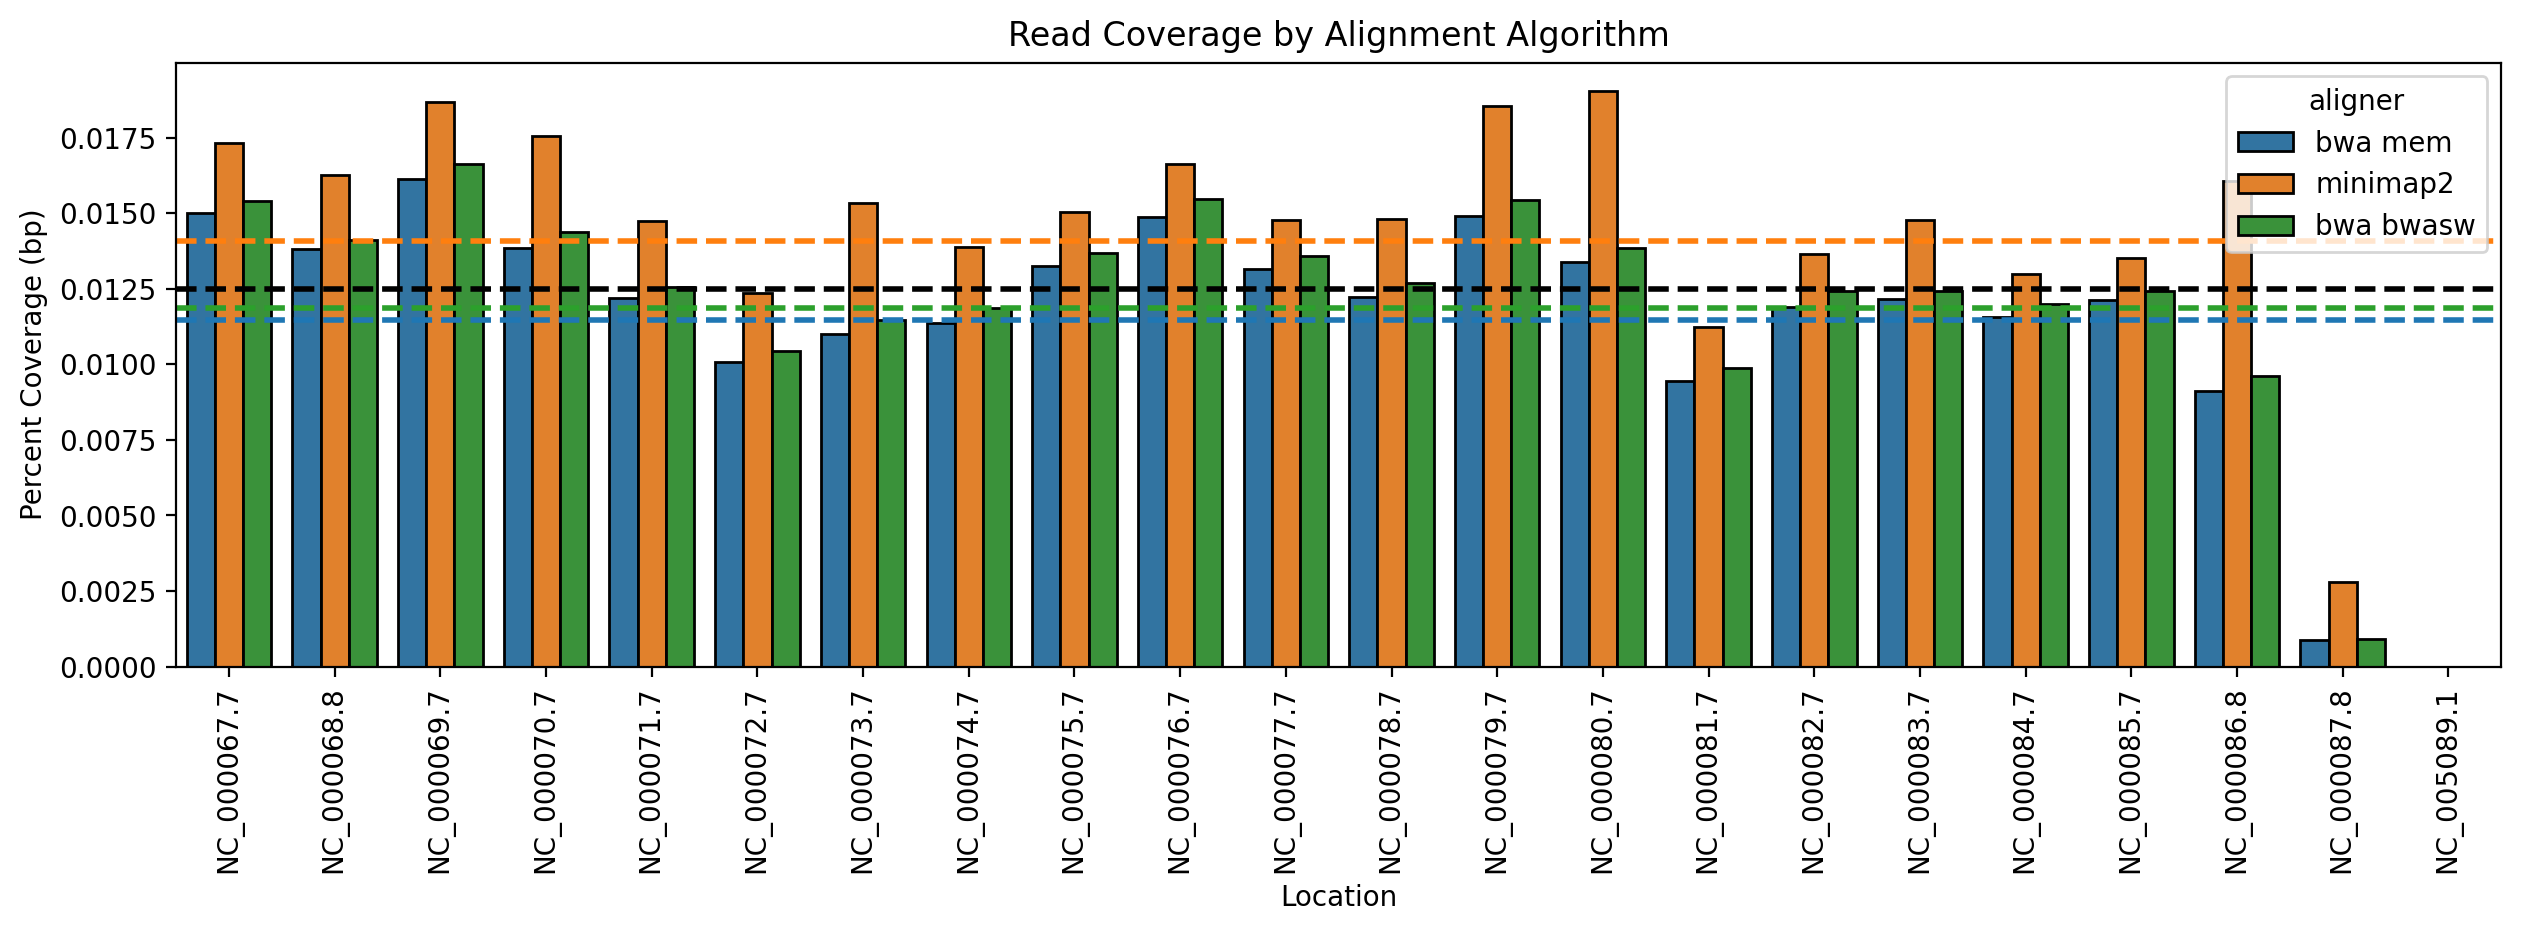

In [5]:

tmp = df[df['rname'].str.contains("NC")]

mem_mean = tmp[tmp['aligner'] == 'bwa mem']['perc_coverage'].mean()
bwasw_mean = tmp[tmp['aligner'] == 'bwa bwasw']['perc_coverage'].mean()
mm2_mean = tmp[tmp['aligner'] == 'minimap2']['perc_coverage'].mean()
mean_coverage = tmp['perc_coverage'].mean()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = (15, 4)
sns.barplot(data=tmp,
            x='rname',
            y='perc_coverage',
            hue='aligner',
            edgecolor='k')


plt.axhline(y=mem_mean, c='C0', ls='--', lw=2)
plt.axhline(y=bwasw_mean, c='C2', ls='--', lw=2)
plt.axhline(y=mm2_mean, c='C1', ls='--', lw=2)
plt.axhline(y=mean_coverage, c='k', ls='--', lw=2)

plt.title("Read Coverage by Alignment Algorithm")
plt.ylabel("Percent Coverage (bp)")
plt.xlabel("Location")
plt.xticks(rotation=90)

In [6]:
"""look at coverage"""

mem_path = "../../tmp/mem/incidence_table.csv"
bwasw_path = "../../tmp/bwasw/incidence_table.csv"
mm2_path = "../../tmp/mm2/incidence_table.csv"

mem = pd.read_csv(mem_path)
bwasw = pd.read_csv(bwasw_path)
mm2 = pd.read_csv(mm2_path)

mem['aligner'] = 'bwa mem'
bwasw['aligner'] = 'bwa bwasw'
mm2['aligner'] = 'minimap2'

df = pd.concat([mem, bwasw, mm2], ignore_index=True)
df.head()

,read_name,cardinality,max_contact_distance,contact_midpoints,fragment_ids,aligner
0,6e3e2746-4ff1-436a-a6a1-2f7863500ada,9,283934,60446450;60614230;60614020;60445526;60331765;6...,11740273;11740867;11740861;11740893;11741746;1...,bwa mem
1,6514b854-2290-4ebf-ac98-cc419357d153,7,18399094,42090244;42090125;23729482;23729904;23691150;2...,11561355;11647850;11649591;11561167;11649590;1...,bwa mem
2,266c4de0-1e64-42b9-ba28-c446534576c7,7,35768364,42503357;42426216;6841286;6841792;42609650;424...,11481278;11651132;11481281;11651499;11652000;1...,bwa mem
3,4c46b32b-d4b0-4b92-91c1-b245d87aeb1b,6,27462260,41679305;41679682;41679038;14217422;41678571;4...,11647669;11647673;11515143;11647507;11647675;1...,bwa mem
4,d292fde0-3cfd-4924-834d-9be576c8b50b,6,523262,27549391;27114663;27636208;27635978;27114906;2...,11578405;11578406;11581084;11580658;11581093;1...,bwa mem


In [7]:
hash_name = lambda s: int(hashlib.sha1(s.encode("utf-8")).hexdigest(), 16) % (10 ** 8)
df['read_int'] = df['read_name'].apply(hash_name)

In [8]:
get_min = lambda x : min([int(i) for i in x.split(";")])
df['min_first_node'] = df['contact_midpoints'].apply(get_min)

In [9]:
df.head()

,read_name,cardinality,max_contact_distance,contact_midpoints,fragment_ids,aligner,read_int,min_first_node
0,6e3e2746-4ff1-436a-a6a1-2f7863500ada,9,283934,60446450;60614230;60614020;60445526;60331765;6...,11740273;11740867;11740861;11740893;11741746;1...,bwa mem,5997219,60330296
1,6514b854-2290-4ebf-ac98-cc419357d153,7,18399094,42090244;42090125;23729482;23729904;23691150;2...,11561355;11647850;11649591;11561167;11649590;1...,bwa mem,27372948,23691150
2,266c4de0-1e64-42b9-ba28-c446534576c7,7,35768364,42503357;42426216;6841286;6841792;42609650;424...,11481278;11651132;11481281;11651499;11652000;1...,bwa mem,89715247,6841286
3,4c46b32b-d4b0-4b92-91c1-b245d87aeb1b,6,27462260,41679305;41679682;41679038;14217422;41678571;4...,11647669;11647673;11515143;11647507;11647675;1...,bwa mem,4986835,14217422
4,d292fde0-3cfd-4924-834d-9be576c8b50b,6,523262,27549391;27114663;27636208;27635978;27114906;2...,11578405;11578406;11581084;11580658;11581093;1...,bwa mem,71918616,27114663


Text(0.5, 1.0, 'Hypergraph Representation of SC Pore-C')

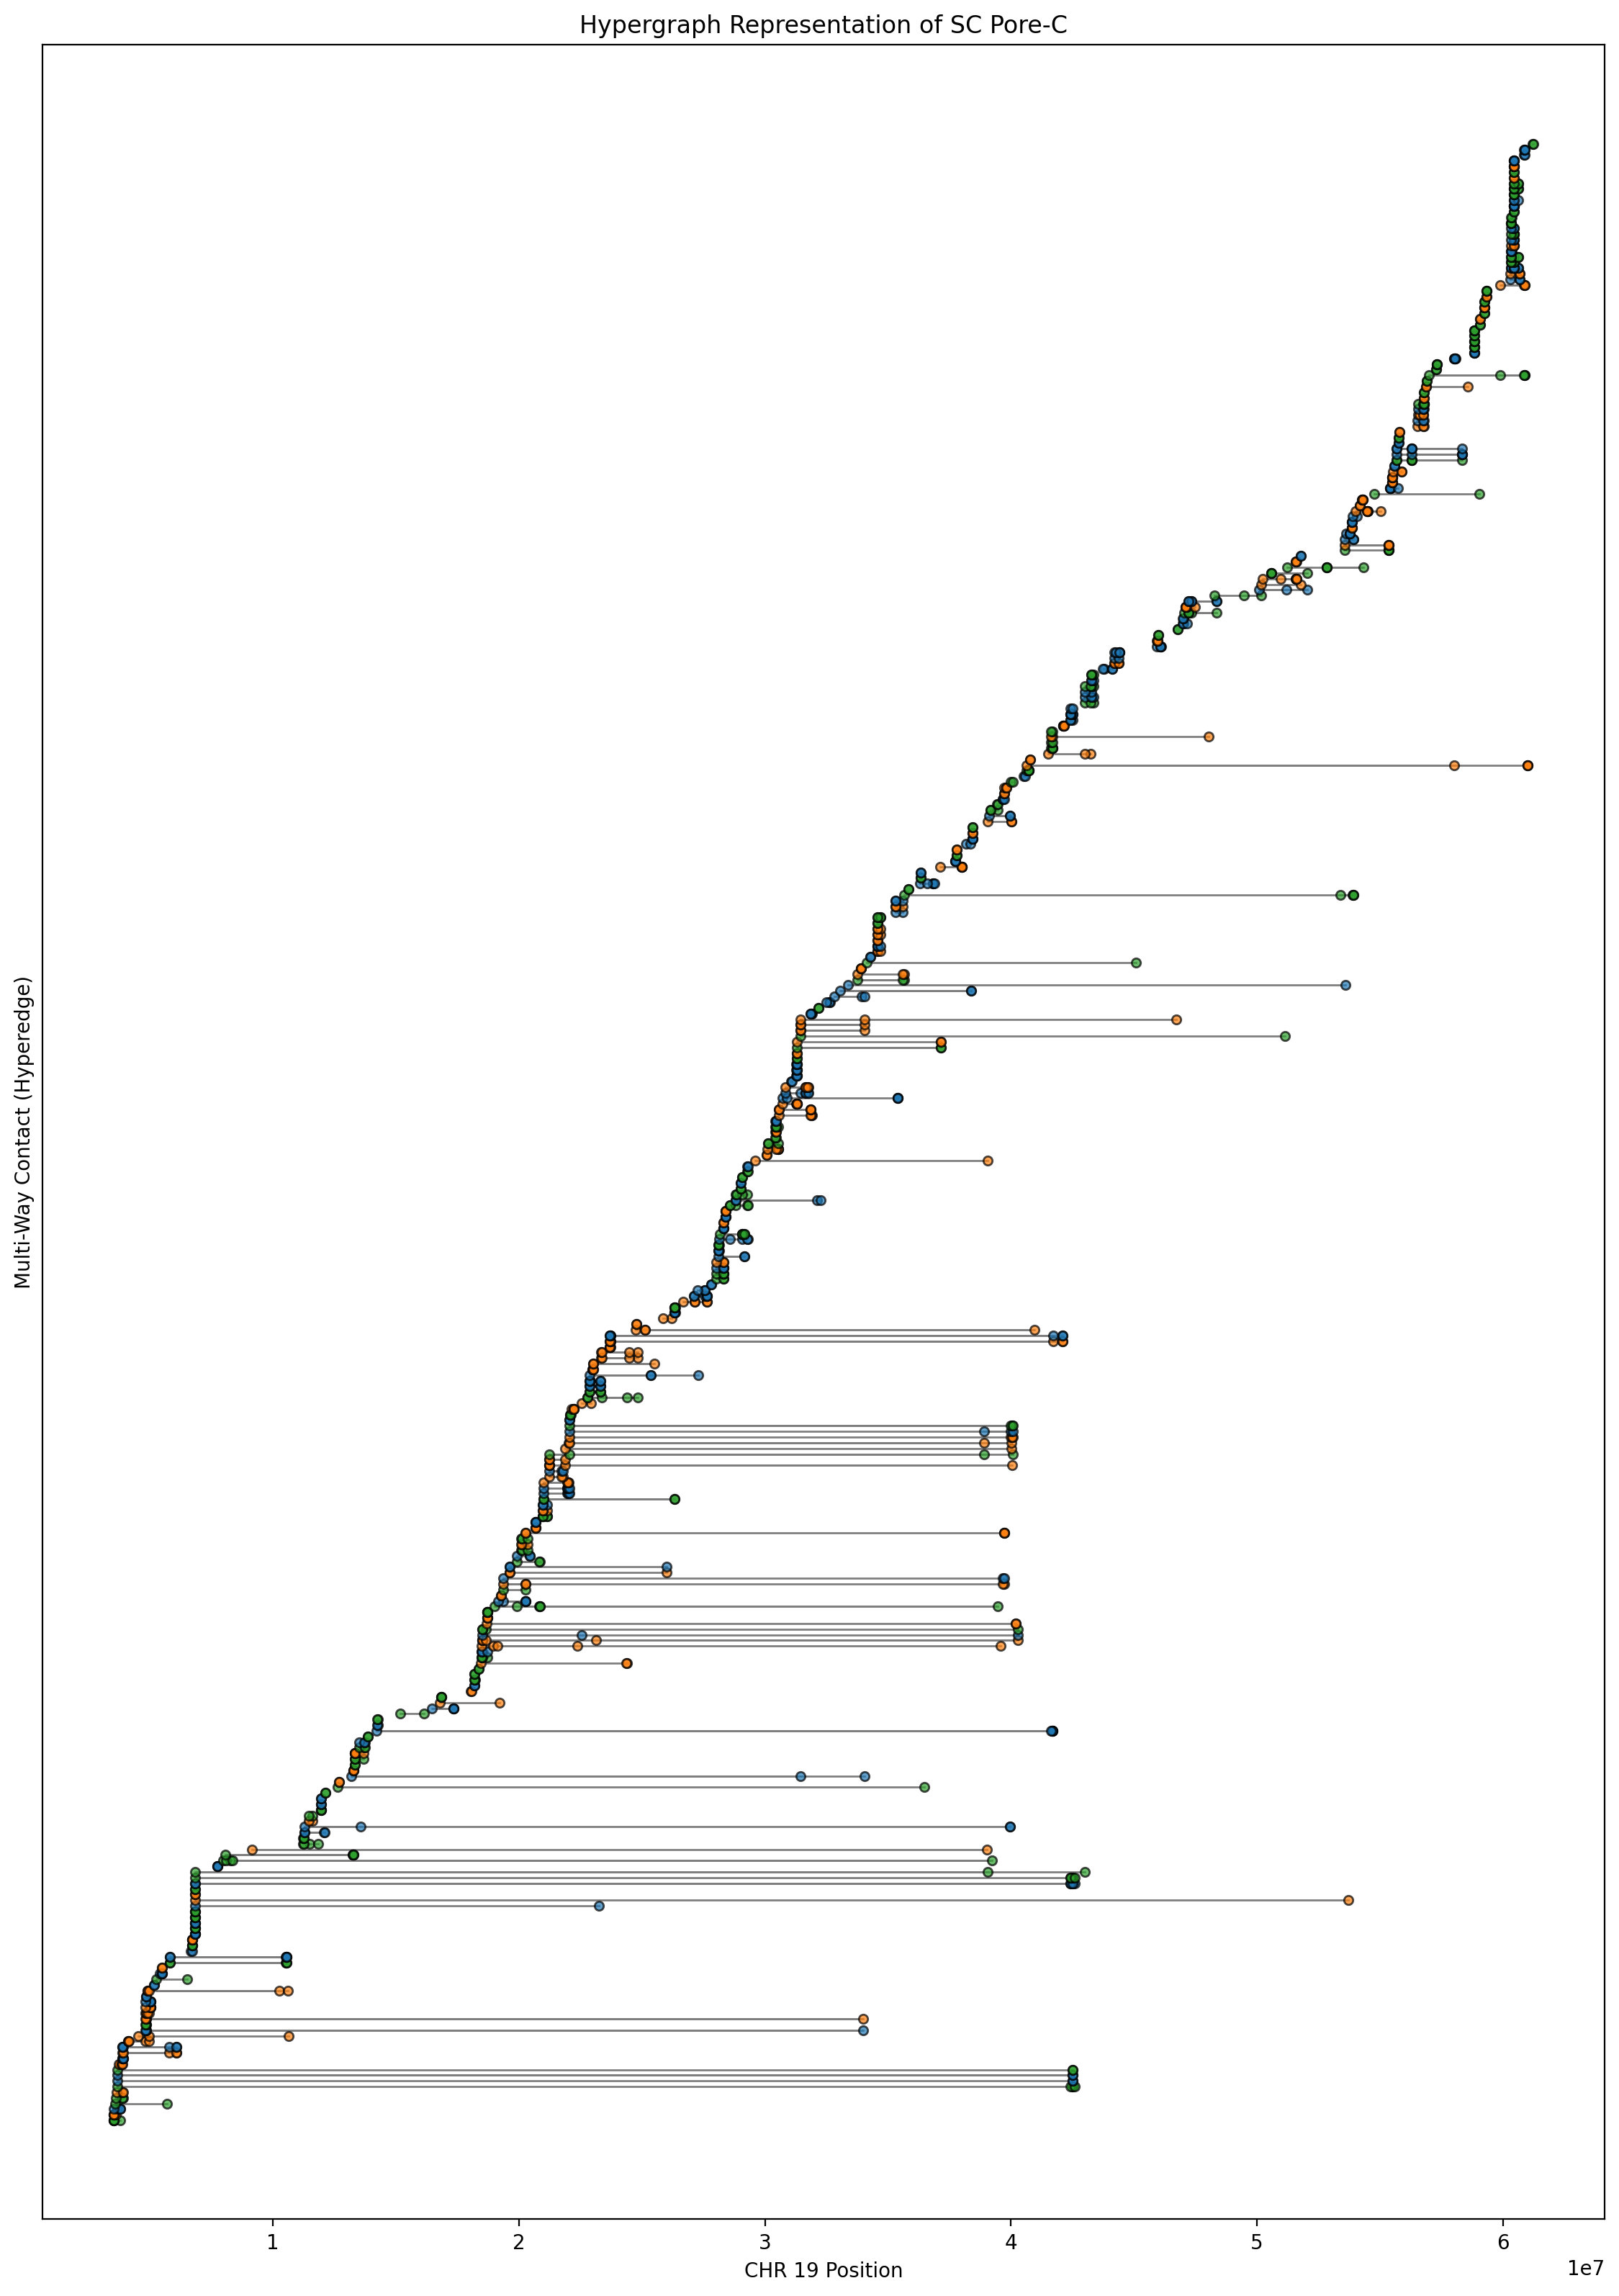

In [10]:
df = df.sort_values(by=['min_first_node']).reset_index(drop=True)

matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (14, 20)

node_color = {
    'bwa mem' : 'C0',
    'bwa bwasw' : 'C1',
    'minimap2' : 'C2'
}

for i, row in df.iterrows():
    contacts = [int(x) for x in row['contact_midpoints'].split(";")]
    read = [i] * len(contacts)
#     card = [float(row['cardinality']) **2] * len(contacts)  # dynamic sizing based on hyperedge cardinality
    
    c = row['aligner']
    
    plt.plot(contacts, 
             read,
             c='k', 
             alpha=0.5,
             lw=1, 
             zorder=1)
    
    plt.scatter(contacts, 
                read, 
                s=20, 
                facecolor=node_color[c], 
                label=c,
                edgecolor='k',
                zorder=2,
                alpha=0.7)

# plt.grid(True)
# plt.rc('grid', linestyle=":", color='k', alpha=0.5)

plt.yticks([])
# plt.xticks([])

# plt.legend()
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.ylabel("Multi-Way Contact (Hyperedge)")
plt.xlabel("CHR 19 Position")
plt.title(f"Hypergraph Representation of SC Pore-C")     

In [11]:
def get_node_dict(df):
    """A function to number the unique nodes for compact plotting"""
    splitter = lambda x: x.split(";")
    nodes = df['contact_midpoints'].apply(splitter)
    
    nodes = [int(x) for x in itertools.chain(*nodes)]
    nodes = sorted(list(set(nodes)))
    node_dict = dict(zip(nodes, list(range(len(nodes)))))

    return node_dict
    
node_dict = get_node_dict(mem)

Text(0.5, 1.0, 'Hypergraph Representation of SC Pore-C (minimap2)')

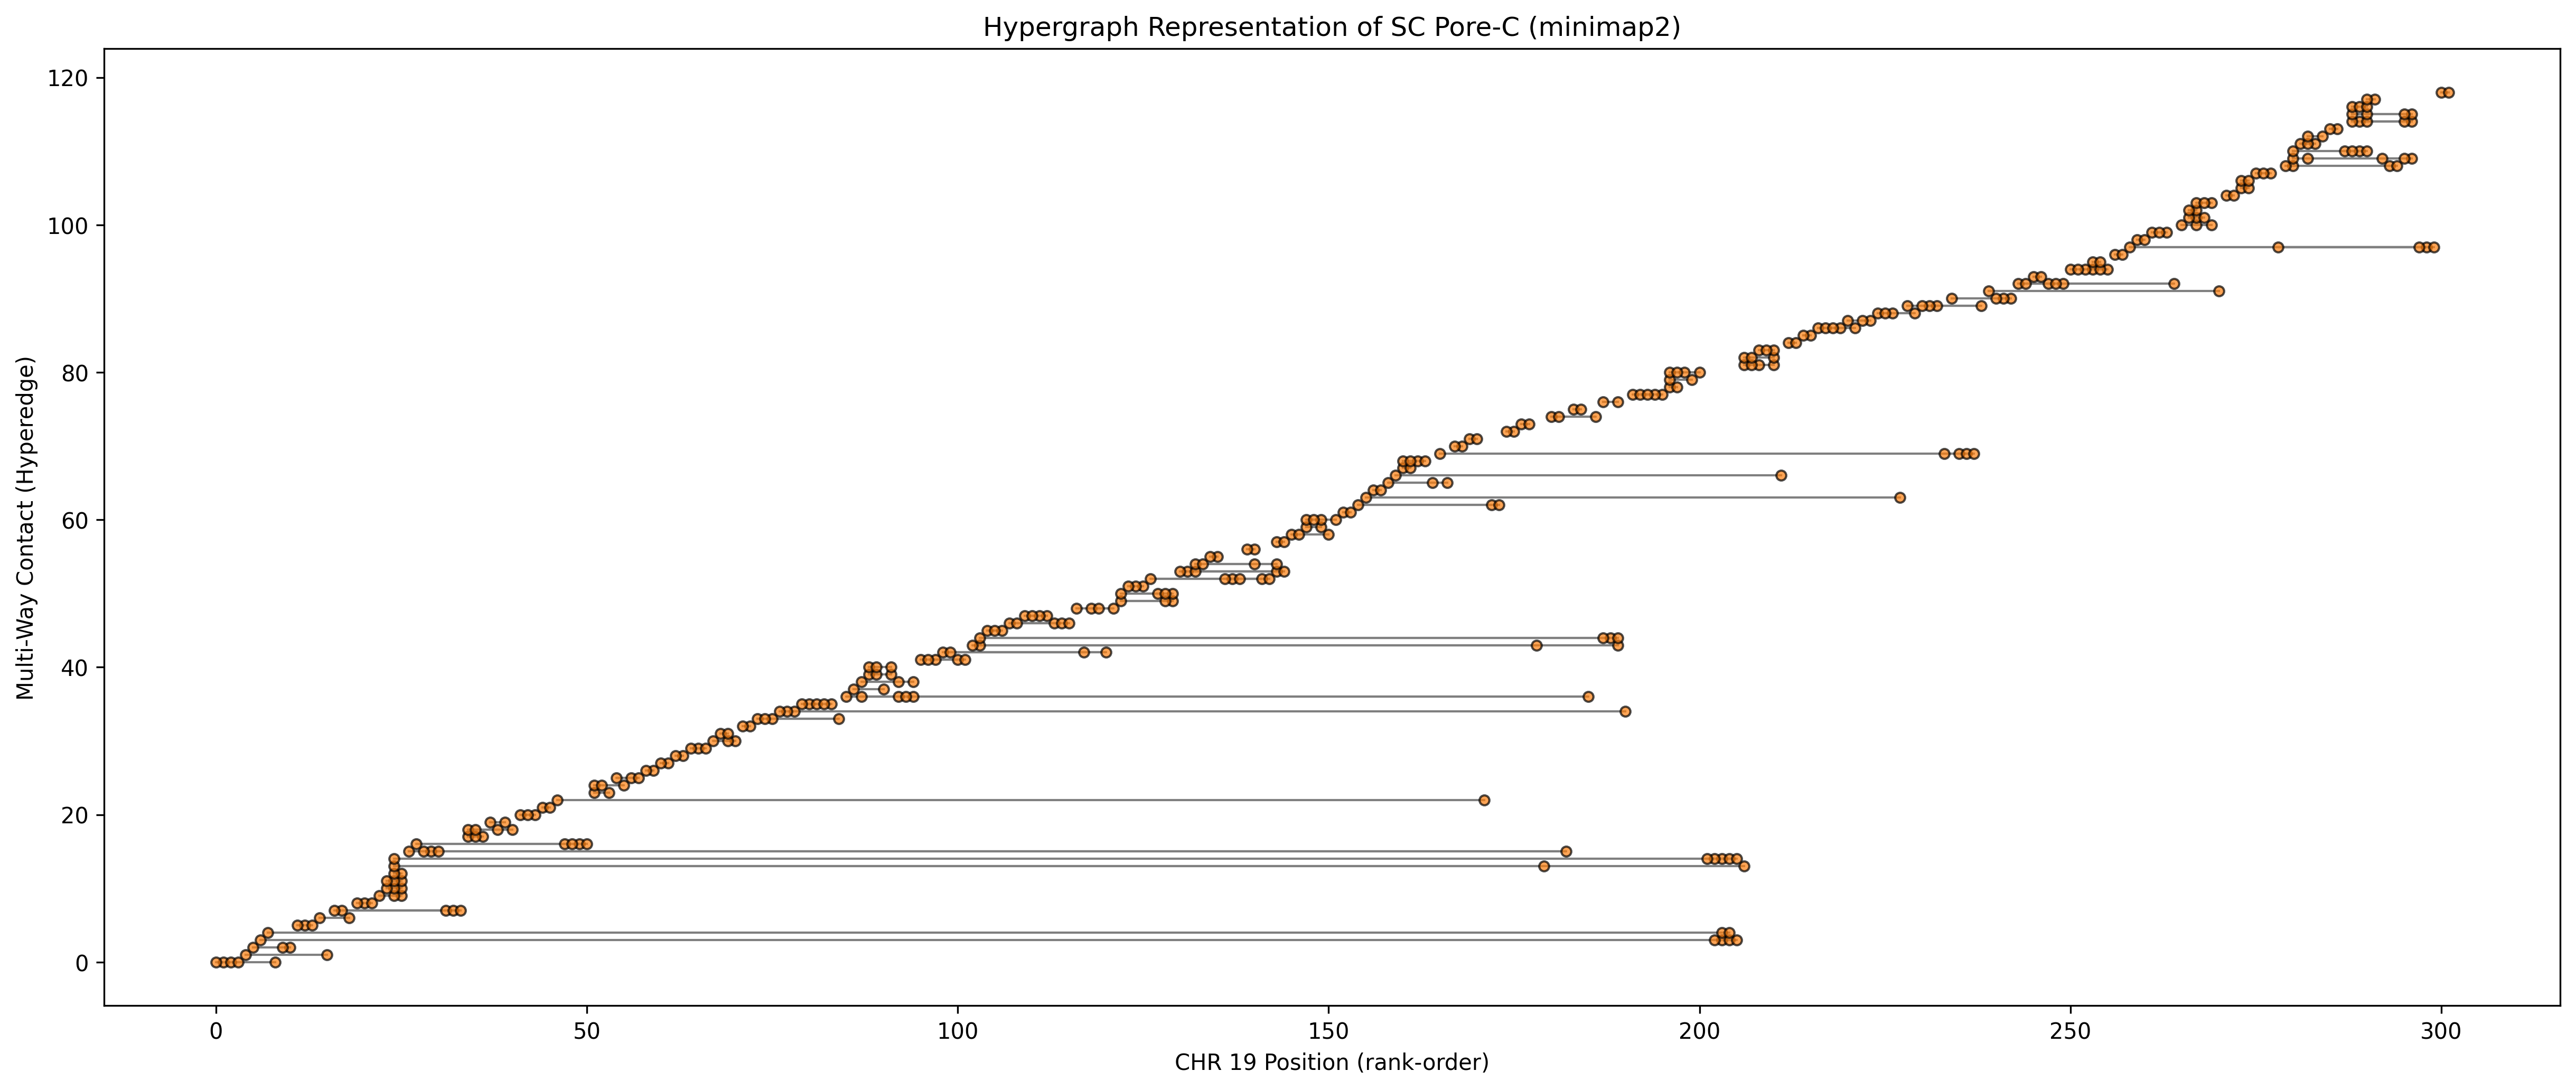

In [12]:
tmp = mm2
color = 'C1'
size = 20

get_min = lambda x : min([int(i) for i in x.split(";")])
tmp['min_first_node'] = tmp['contact_midpoints'].apply(get_min)
tmp = tmp.sort_values(by=['min_first_node']).reset_index(drop=True)
node_dict = get_node_dict(tmp)

matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['figure.figsize'] = (20, 8)

for i, row in tmp.iterrows():
    contacts = [node_dict[int(x)] for x in row['contact_midpoints'].split(";")]
    read = [i] * len(contacts)
    
    plt.plot(contacts, 
             read,
             c='k', 
             alpha=0.5,
             lw=1, 
             zorder=1)
    
    plt.scatter(contacts, 
                read, 
                s=size, 
                facecolor=color, 
                label=c,
                edgecolor='k',
                zorder=2,
                alpha=0.7)
    
plt.ylabel("Multi-Way Contact (Hyperedge)")
plt.xlabel("CHR 19 Position (rank-order)")
plt.title(f"Hypergraph Representation of SC Pore-C (minimap2)")     

Text(0.5, 1.0, 'Cardinality of Hyperedges (CHR 19) ')

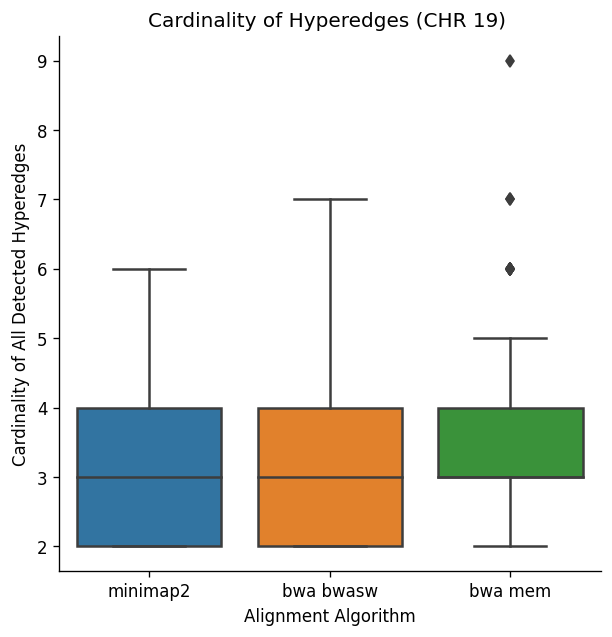

In [20]:
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = (4, 4)
sns.catplot(data=df,
            x="aligner", 
            y="cardinality", 
            kind="box",
            dodge=False)

plt.ylabel("Cardinality of All Detected Hyperedges")
plt.xlabel("Alignment Algorithm")
plt.title(f"Cardinality of Hyperedges (CHR 19) ")  

Text(0.5, 1.0, 'Max Contact Distance (CHR 19) ')

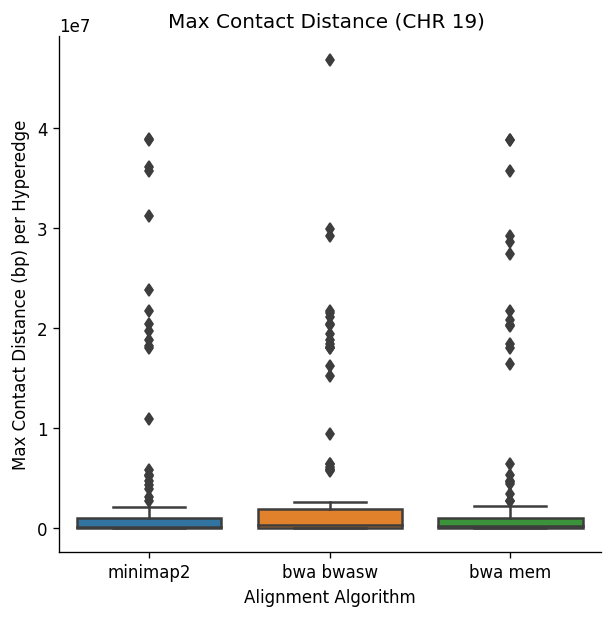

In [21]:
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = (4, 4)
sns.catplot(data=df,
            x="aligner", 
            y="max_contact_distance", 
            kind="box",
            dodge=False,
            showfliers=False)

plt.ylabel("Max Contact Distance (bp) per Hyperedge")
plt.xlabel("Alignment Algorithm")
plt.title(f"Max Contact Distance (CHR 19) ")  

In [ ]:
sns.scatterplot(data=df,
                x="max_contact_distance", 
                y="cardinality")

# plt.ylabel("Cardinality of All Detected Hyperedges")
# plt.xlabel("Alignment Algorithm")
# plt.title(f"Cardinality of Hyperedges (CHR 19) ")  